# 02. Walk-Forward Retraining and Drift Diagnostics

This notebook illustrates rolling retraining and drift tracking.

Diagnostics produced per consecutive fold pair:

- transition matrix drift (`fro_norm_delta`, `mean_abs_delta`, `max_abs_delta`)
- overlapping-window label flip rate
- log-likelihood drift (old model vs new model on current test slice)


## Why this matters

A static regime model can go stale. Walk-forward diagnostics help answer:

- Is regime structure stable over time?
- Are labels consistent from fold to fold?
- Is model fit degrading on newer data?


In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from hmm_regime.data import download_openbb_prices
from hmm_regime.model import HMMConfig
from hmm_regime.walk_forward import run_walk_forward_regime_analysis


In [10]:
# --- Configuration ---
SYMBOL = "SPY"
START_DATE = "2015-01-01"
END_DATE = "2025-12-31"
PROVIDER = "yfinance"
CLOSE_COL = "close"

TRAIN_BARS = 504   # ~2 years (daily)
TEST_BARS = 126    # ~6 months (daily)
STEP_BARS = 63     # ~1 quarter
MIN_TEST_BARS = 20

OUTPUT_DIR = Path("../outputs/notebook_wf_spy")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

HMM_CFG = HMMConfig(
    n_states=3,
    covariance_type="full",
    n_iter=300,
    tol=1e-4,
    random_state=42,
)


In [11]:
# --- Step 1: Download prices ---
prices = download_openbb_prices(
    symbol=SYMBOL,
    start_date=START_DATE,
    end_date=END_DATE,
    provider=PROVIDER,
    close_col=CLOSE_COL,
)

print(f"rows={len(prices)}")
print(f"start={prices.index.min()}  end={prices.index.max()}")


rows=2766
start=2015-01-02 00:00:00  end=2025-12-31 00:00:00


In [12]:
# --- Step 2: Run walk-forward retraining + drift diagnostics ---
wf = run_walk_forward_regime_analysis(
    prices,
    close_col=CLOSE_COL,
    hmm_config=HMM_CFG,
    train_bars=TRAIN_BARS,
    test_bars=TEST_BARS,
    step_bars=STEP_BARS,
    min_test_bars=MIN_TEST_BARS,
)

print("n_folds:", len(wf.folds))


Model is not converging.  Current: 5694.45788265556 is not greater than 5694.458281527408. Delta is -0.0003988718481195974
Model is not converging.  Current: 6167.601734979255 is not greater than 6167.6017693975. Delta is -3.4418245377310086e-05
Model is not converging.  Current: 5680.813506701345 is not greater than 5680.828279923086. Delta is -0.014773221740142617
Model is not converging.  Current: 5106.083743149486 is not greater than 5140.585071278717. Delta is -34.5013281292313
Model is not converging.  Current: 4562.69129455768 is not greater than 4562.70593211994. Delta is -0.014637562260759296
Model is not converging.  Current: 4190.997684208558 is not greater than 4191.258126593287. Delta is -0.26044238472877623
Model is not converging.  Current: 5404.562863978224 is not greater than 5404.563288449945. Delta is -0.00042447172018000856
Model is not converging.  Current: 5390.131927644256 is not greater than 5390.13215242895. Delta is -0.00022478469327325001
Model is not converg

n_folds: 36


In [13]:
# --- Step 3: Save artifacts ---
folds_path = OUTPUT_DIR / "walk_forward_folds.csv"
trans_drift_path = OUTPUT_DIR / "drift_transition.csv"
flip_path = OUTPUT_DIR / "drift_label_flip.csv"
ll_path = OUTPUT_DIR / "drift_loglik.csv"

wf.folds.to_csv(folds_path, index=True)
wf.drift_transition.to_csv(trans_drift_path, index=True)
wf.drift_label_flip.to_csv(flip_path, index=True)
wf.drift_loglik.to_csv(ll_path, index=True)

print("Saved files:")
for p in [folds_path, trans_drift_path, flip_path, ll_path]:
    print("-", p.resolve())


Saved files:
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_wf_spy/walk_forward_folds.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_wf_spy/drift_transition.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_wf_spy/drift_label_flip.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_wf_spy/drift_loglik.csv


In [14]:
# --- Step 4: Inspect tabular outputs ---
display(wf.folds.head(10))
display(wf.drift_transition.head(10))
display(wf.drift_label_flip.head(10))
display(wf.drift_loglik.head(10))


,train_start,train_end,test_start,test_end,n_train,n_test,train_loglik_per_obs,test_loglik_per_obs,share_calm,share_neutral,share_stress,share_other
fold,,,,,,,,,,,,
1,2015-01-02,2016-12-30,2017-01-03,2017-07-03,379,126,13.841855,15.210195,1.000000,0.000000,0.000000,0.000000e+00
2,2015-04-06,2017-04-03,2017-04-04,2017-10-02,379,126,14.679530,14.531584,0.523810,0.468254,0.007937,0.000000e+00
3,2015-07-06,2017-07-03,2017-07-05,2018-01-02,379,126,15.024955,15.639747,0.984127,0.007937,0.007937,1.110223e-16
4,2015-10-02,2017-10-02,2017-10-03,2018-04-04,379,126,15.176056,4.912102,0.444444,0.555556,0.000000,0.000000e+00
5,2016-01-04,2018-01-02,2018-01-03,2018-07-03,379,126,17.359120,-76.482387,0.158730,0.023810,0.817460,0.000000e+00
6,2016-04-05,2018-04-04,2018-04-05,2018-10-02,379,126,16.273355,8.542762,0.380952,0.523810,0.095238,0.000000e+00
7,2016-07-05,2018-07-03,2018-07-05,2019-01-03,379,126,15.680771,10.362316,0.246032,0.293651,0.460317,0.000000e+00
8,2016-10-03,2018-10-02,2018-10-03,2019-04-04,379,126,16.045018,3.263122,0.039683,0.952381,0.007937,1.110223e-16
9,2017-01-03,2019-01-03,2019-01-04,2019-07-05,379,126,14.988916,-4.767601,0.079365,0.015873,0.904762,0.000000e+00


,,mean_abs_delta,max_abs_delta,fro_norm_delta
prev_fold,curr_fold,,,
1,2,0.021993,0.047293,0.081970
2,3,0.020277,0.041759,0.075942
3,4,0.540098,0.996280,2.005538
4,5,0.527229,0.999911,1.983231
5,6,0.018511,0.055007,0.076056
6,7,0.446290,0.997955,1.879602
7,8,0.442244,0.997955,1.879102
8,9,0.060005,0.117814,0.233364
9,10,0.129663,0.541899,0.753501


,,n_overlap,flip_rate
prev_fold,curr_fold,,
1,2,63,0.587302
2,3,63,0.396825
3,4,63,0.507937
4,5,63,0.857143
5,6,63,0.873016
6,7,63,0.555556
7,8,63,0.952381
8,9,63,0.984127
9,10,63,0.238095


,,prev_model_loglik_per_obs_on_curr_test,curr_model_loglik_per_obs_on_curr_test,delta_loglik_per_obs
prev_fold,curr_fold,,,
1,2,15.226694,14.531584,-0.695110
2,3,15.784612,15.639747,-0.144865
3,4,9.146359,4.912102,-4.234257
4,5,-8.962022,-76.482387,-67.520365
5,6,-41.485103,8.542762,50.027865
6,7,0.490204,10.362316,9.872112
7,8,5.205460,3.263122,-1.942338
8,9,3.379438,-4.767601,-8.147038
9,10,11.402952,10.365401,-1.037551


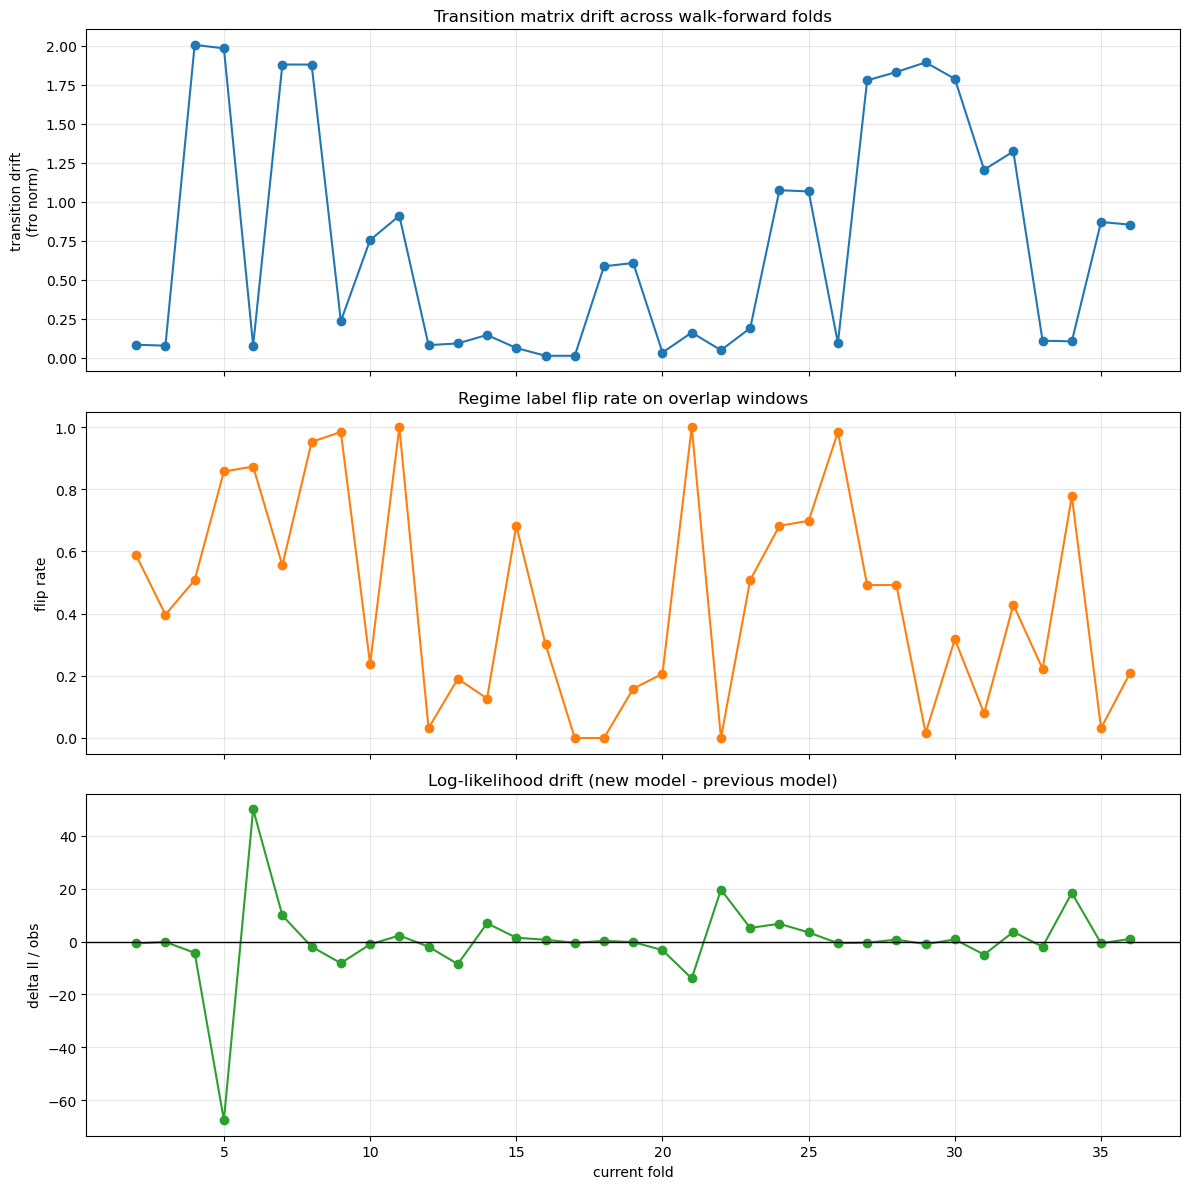

In [15]:
# --- Step 5: Plot drift signals ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

if not wf.drift_transition.empty:
    dt = wf.drift_transition.reset_index()
    axes[0].plot(dt["curr_fold"], dt["fro_norm_delta"], marker="o")
axes[0].set_ylabel("transition drift\n(fro norm)")
axes[0].set_title("Transition matrix drift across walk-forward folds")
axes[0].grid(alpha=0.3)

if not wf.drift_label_flip.empty:
    df = wf.drift_label_flip.reset_index()
    axes[1].plot(df["curr_fold"], df["flip_rate"], marker="o", color="tab:orange")
axes[1].set_ylabel("flip rate")
axes[1].set_title("Regime label flip rate on overlap windows")
axes[1].grid(alpha=0.3)

if not wf.drift_loglik.empty:
    dl = wf.drift_loglik.reset_index()
    axes[2].plot(dl["curr_fold"], dl["delta_loglik_per_obs"], marker="o", color="tab:green")
    axes[2].axhline(0.0, color="black", lw=1)
axes[2].set_xlabel("current fold")
axes[2].set_ylabel("delta ll / obs")
axes[2].set_title("Log-likelihood drift (new model - previous model)")
axes[2].grid(alpha=0.3)

plt.tight_layout()


In [16]:
# --- Step 6: Identify most unstable transitions ---
if wf.drift_transition.empty:
    print("No drift rows available.")
else:
    unstable = (
        wf.drift_transition
        .reset_index()
        .sort_values("fro_norm_delta", ascending=False)
        .head(10)
    )
    display(unstable)


,prev_fold,curr_fold,mean_abs_delta,max_abs_delta,fro_norm_delta
2,3,4,0.540098,0.996280,2.005538
3,4,5,0.527229,0.999911,1.983231
27,28,29,0.434856,0.980110,1.893271
5,6,7,0.446290,0.997955,1.879602
6,7,8,0.442244,0.997955,1.879102
26,27,28,0.406478,0.988663,1.831318
28,29,30,0.409754,0.979401,1.787535
25,26,27,0.402048,0.929720,1.777930
30,31,32,0.217641,0.934205,1.321859
29,30,31,0.194310,0.851654,1.204622


## Practical Interpretation

Use these diagnostics together:

- **High transition drift + high label flips**: regime definitions are moving; treat labels cautiously.
- **Large negative log-likelihood delta**: previous fold model generalizes poorly to new slice.
- **Persistent instability clusters**: likely structural break windows; consider adaptive features or shorter retrain windows.

Potential mitigations:
- reduce feature complexity,
- retrain more frequently,
- add posterior confidence thresholds before downstream strategy actions.
